# Implementing self-healing autonomous software-defined IIoT-Edge networks for offshore wind power plants

* @Contributor 1: Agrippina Mwangi (Utrecht University, The Netherlands)
* @Contributor 2: León Navarro-Hilfiker (Ørsted, USA)

Topic Summary:
> Software-defined Industrial Internet of Things -
Edge (IIoT-Edge) networks in offshore Wind Power Plants
(WPPs) enforce rigorous Service Level Agreements (SLAs) and
Quality of Service (QoS) requirements to ensure reliable trans-
mission of critical time-sensitive and best-effort data traffic. 

>On occasion, these IIoT-Edge networks experience flash events of
benign traffic flows which cause network congestion resulting
in intermittent network service interruptions. Further, given
the intricacies of the offshore environment, these IIoT-Edge
network equipment are exposed to extreme temperature profiles
which cause physical damage, degrade equipment performance,
and shorten their overall lifespan by 50%. 

>To mitigate these
two stochastic disruptions, this paper proposes an externally
adapted “Observe–Orient–Decide–Act” closed control loop self-
healing framework. This framework autonomously monitors
the operating temperature profiles of the IIoT-Edge network
equipment, detects traffic anomalies, and initiates corrective
actions through a threshold-triggered Deep Q-Network (DQN)
self-healing agent. These corrective actions reroute traffic to
avoid congested paths and overheated switches and throttle low-
priority traffic based on service type classification in extreme
cases.
(https://github.com/PinaPhD/testbed/blob/main/docs/_static/Images/selfheal.png)

Graphical Abstract:

![Self healing framework](selfheal.png)


Importing relevant libraries:

In [1]:
import requests
import time
import logging
import pandas as pd
import numpy as np
from time import strftime
from datetime import datetime
import os
import networkx as nx
import matplotlib.pyplot as plt


## OBSERVE MODULE

> Interacts with the ONOS SDN Controllers for the different ASes of the triple Wind Power Plant cluster through RESTful API endpoints (with OAUTH 2.0 access token for secure authentication and authorization). 

#### 1. Connecting to the ONOS SDN Controller via RESTful APIs from the Knowledge Plane

In [2]:
'''
        ONOS SDN controller cluster interacting with the Knowledge Base
        Connecting to the primary SDN controller using a 8181 RESTful API based url and 
        with OAuth 2.0 access token for secure authentication and authorization.
'''


# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Prompting user for ONOS controller details
print("OBSERVE MODULE AS(n) OT Network Topology.\n\nDisclaimer: Press ENTER if you wish to use the default configurations.\n")
controller_ip = input("Enter the IP address of the ONOS controller (default is 192.168.0.6: )")
controller_ip = controller_ip if controller_ip else '192.168.0.6'
onos_base_url = f'http://{controller_ip}:8181/onos/v1'

username = input("Enter the username for ONOS controller (default is 'onos'): ")
username = username if username else 'onos'
password = input("Enter the password for ONOS controller (default is 'rocks'): ")
password = password if password else 'rocks'
onos_auth = (username, password)


OBSERVE MODULE AS(n) OT Network Topology.

Disclaimer: Press ENTER if you wish to use the default configurations.

Enter the IP address of the ONOS controller (default is 192.168.0.6: )
Enter the username for ONOS controller (default is 'onos'): 
Enter the password for ONOS controller (default is 'rocks'): 


#### 2. Reading the Control and Data Plane Metrics using RESTful API Requests

In [3]:
def get_devices():
    """ 
        Fetches network devices from the ONOS controller. 
    """
    
    try:
        response = requests.get(f'{onos_base_url}/devices', auth=onos_auth)
        if response.status_code == 200:
            devices = response.json().get('devices', [])
            df = pd.DataFrame(devices)
            return df
        else:
            print(f"Failed to retrieve Network devices: Status code {response.status_code} - {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching Network devices: {e}")

def get_links():
    """ 
        Fetches network links from the ONOS controller. 
    """
    
    try:
        response = requests.get(f'{onos_base_url}/links', auth=onos_auth)
        if response.status_code == 200:
            links = response.json().get('links', [])
            df = pd.DataFrame(links)
            return df
        else:
            print(f"Failed to retrieve Network links: Status code {response.status_code} - {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching Network Links: {e}")

def get_hosts():
    """ 
        Fetches network hosts from the ONOS controller. 
    """

    try:
        response = requests.get(f'{onos_base_url}/hosts', auth=onos_auth)
        if response.status_code == 200:
            hosts = response.json().get('hosts', [])
            df = pd.DataFrame(hosts)
            return df
        else:
            print(f"Failed to retrieve Network hosts: Status code {response.status_code} - {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching Network hosts: {e}")

def get_flows():
    """ 
        Fetches flow rules from the ONOS controller. 
    """
    
    try:
        response = requests.get(f'{onos_base_url}/flows', auth=onos_auth)
        if response.status_code == 200:
            flows = response.json().get('flows', [])
            df = pd.DataFrame(flows)
            return df
        else:
            print(f"Failed to retrieve Network flows: Status code {response.status_code} - {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching Network flows: {e}")


def get_port_statistics():
    """ 
        Fetches port statistics from all devices in the ONOS controller. 
    """
    
    try:
        response = requests.get(f'{onos_base_url}/statistics/ports', auth=onos_auth)
        if response.status_code == 200:
            port_stats = response.json().get('statistics', [])
            # Flatten the nested JSON structure for easier CSV writing
            flattened_stats = []
            for device in port_stats:
                device_id = device['device']
                for port in device['ports']:
                    port['device'] = device_id
                    flattened_stats.append(port)
            df = pd.DataFrame(flattened_stats)
            return df
        else:
            print(f"Failed to retrieve Port Statistics: Status code {response.status_code} - {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching network port statistics: {e}")


#For the paths
def get_devices_fp():
    response = requests.get(f'{onos_base_url}/devices', auth=onos_auth)
    return response.json()

# Function to get links
def get_links_fp():
    response = requests.get(f'{onos_base_url}/links', auth=onos_auth)
    return response.json()

#Determine the source to destination paths
def find_all_paths(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]
    if start not in graph:
        return []
    paths = []
    for node in graph[start]:
        if node not in path:
            newpaths = find_all_paths(graph, node, end, path)
            for newpath in newpaths:
                paths.append(newpath)
    return paths

# Generating the links between the source and destination paths
def src_to_dest_paths():
    devices = get_devices_fp()['devices']
    links = get_links_fp()['links']
    
    # Build adjacency list for the graph
    graph = {}
    for link in links:
        src = link['src']['device']
        dst = link['dst']['device']
        if src not in graph:
            graph[src] = []
        if dst not in graph:
            graph[dst] = []
        graph[src].append(dst)
        graph[dst].append(src)
    
    # Iterate over each pair of devices to find all paths
    device_ids = [device['id'] for device in devices]
    paths_list = []
    
    for i in range(len(device_ids)):
        for j in range(i + 1, len(device_ids)):
            source_device = device_ids[i]
            destination_device = device_ids[j]
            
            # Find all paths
            paths = find_all_paths(graph, source_device, destination_device)
            
            # Store paths
            for path in paths:
                paths_list.append({
                    'source': source_device,
                    'destination': destination_device,
                    'path': " -> ".join(path)
                })

    df_paths = pd.DataFrame(paths_list)
    return df_paths



In [4]:
devices = get_devices()
devices

,id,type,available,role,mfr,hw,sw,serial,driver,chassisId,lastUpdate,humanReadableLastUpdate,annotations
0,of:000000000000000c,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,c,1726822541742,connected 38s ago,"{'channelId': '192.168.0.5:60652', 'management..."
1,of:000000000000000d,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,d,1726822541645,connected 38s ago,"{'channelId': '192.168.0.5:60574', 'management..."
2,of:000000000000000a,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,a,1726822541638,connected 38s ago,"{'channelId': '192.168.0.5:60560', 'management..."
3,of:000000000000000b,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,b,1726822541787,connected 37s ago,"{'channelId': '192.168.0.5:60712', 'management..."
4,of:000000000000000e,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,e,1726822541698,connected 38s ago,"{'channelId': '192.168.0.5:60570', 'management..."
5,of:000000000000000f,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,f,1726822541727,connected 38s ago,"{'channelId': '192.168.0.5:60578', 'management..."
6,of:0000000000000010,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,10,1726822542048,connected 37s ago,"{'channelId': '192.168.0.5:60874', 'management..."
7,of:0000000000000011,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,11,1726822542033,connected 37s ago,"{'channelId': '192.168.0.5:60856', 'management..."
8,of:0000000000000014,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,14,1726822541986,connected 37s ago,"{'channelId': '192.168.0.5:60834', 'management..."
9,of:0000000000000015,SWITCH,True,MASTER,"Nicira, Inc.",Open vSwitch,2.17.9,None,ovs,15,1726822542126,connected 37s ago,"{'channelId': '192.168.0.5:60912', 'management..."


In [5]:
hosts = get_hosts()
hosts

,id,mac,vlan,innerVlan,outerTpid,configured,ipAddresses,locations
0,EE:F3:B2:7F:B0:5B/None,EE:F3:B2:7F:B0:5B,None,None,unknown,False,[10.0.1.62],"[{'elementId': 'of:0000000000000021', 'port': ..."
1,66:91:E7:DB:41:CD/None,66:91:E7:DB:41:CD,None,None,unknown,False,[10.0.1.50],"[{'elementId': 'of:0000000000000015', 'port': ..."
2,DE:B5:F8:2C:DC:52/None,DE:B5:F8:2C:DC:52,None,None,unknown,False,[10.0.1.64],"[{'elementId': 'of:0000000000000023', 'port': ..."
3,66:EA:36:69:6A:9F/None,66:EA:36:69:6A:9F,None,None,unknown,False,[10.0.1.67],"[{'elementId': 'of:0000000000000026', 'port': ..."
4,46:44:D9:12:A8:2A/None,46:44:D9:12:A8:2A,None,None,unknown,False,[10.0.1.40],"[{'elementId': 'of:000000000000000c', 'port': ..."
5,BA:DA:15:E8:FB:81/None,BA:DA:15:E8:FB:81,None,None,unknown,False,[10.0.1.78],"[{'elementId': 'of:000000000000001d', 'port': ..."
6,86:6C:3A:7E:CE:1F/None,86:6C:3A:7E:CE:1F,None,None,unknown,False,[10.0.1.77],"[{'elementId': 'of:000000000000001c', 'port': ..."
7,7E:46:10:84:FC:B9/None,7E:46:10:84:FC:B9,None,None,unknown,False,[10.0.1.54],"[{'elementId': 'of:0000000000000019', 'port': ..."
8,D2:62:63:E6:D6:BE/None,D2:62:63:E6:D6:BE,None,None,unknown,False,[10.0.1.76],"[{'elementId': 'of:000000000000001b', 'port': ..."
9,7A:2F:58:CE:78:16/None,7A:2F:58:CE:78:16,None,None,unknown,False,[10.0.1.53],"[{'elementId': 'of:0000000000000018', 'port': ..."


In [6]:
links =get_links()
links

,src,dst,type,state
0,"{'port': '1', 'device': 'of:0000000000000014'}","{'port': '4', 'device': 'of:0000000000000008'}",DIRECT,ACTIVE
1,"{'port': '2', 'device': 'of:0000000000000003'}","{'port': '1', 'device': 'of:0000000000000004'}",DIRECT,ACTIVE
2,"{'port': '3', 'device': 'of:0000000000000001'}","{'port': '1', 'device': 'of:0000000000000015'}",DIRECT,ACTIVE
3,"{'port': '1', 'device': 'of:0000000000000012'}","{'port': '2', 'device': 'of:0000000000000008'}",DIRECT,ACTIVE
4,"{'port': '3', 'device': 'of:0000000000000003'}","{'port': '1', 'device': 'of:0000000000000007'}",DIRECT,ACTIVE
...,...,...,...,...
73,"{'port': '1', 'device': 'of:0000000000000005'}","{'port': '2', 'device': 'of:0000000000000001'}",DIRECT,ACTIVE
74,"{'port': '1', 'device': 'of:0000000000000023'}","{'port': '8', 'device': 'of:0000000000000003'}",DIRECT,ACTIVE
75,"{'port': '3', 'device': 'of:0000000000000008'}","{'port': '1', 'device': 'of:0000000000000013'}",DIRECT,ACTIVE
76,"{'port': '1', 'device': 'of:0000000000000021'}","{'port': '6', 'device': 'of:0000000000000003'}",DIRECT,ACTIVE


In [7]:
flows = get_flows()
flows

,id,tableId,appId,groupId,priority,timeout,isPermanent,deviceId,state,life,packets,bytes,liveType,lastSeen,treatment,selector
0,6755401752200911,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,ADDED,7,0,0,UNKNOWN,1726822577727,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 2}, ..."
1,6755399531756908,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,PENDING_ADD,0,0,0,UNKNOWN,1726822578561,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 2}, ..."
2,6755400194011696,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,PENDING_ADD,0,0,0,UNKNOWN,1726822578559,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 1}, ..."
3,6755401794672395,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,ADDED,7,0,0,UNKNOWN,1726822577727,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 1}, ..."
4,281475624796078,0,org.onosproject.core,0,40000,0,True,of:000000000000000c,ADDED,35,12,1668,UNKNOWN,1726822577727,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'ETH_TYPE', 'ethType': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,6755400991041621,0,org.onosproject.fwd,0,10,10,False,of:0000000000000009,ADDED,3,0,0,UNKNOWN,1726822577775,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 3}, ..."
3004,6755401599264528,0,org.onosproject.fwd,0,10,10,False,of:0000000000000009,ADDED,5,0,0,UNKNOWN,1726822577775,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 2}, ..."
3005,6755403595052432,0,org.onosproject.fwd,0,10,10,False,of:0000000000000009,ADDED,1,0,0,UNKNOWN,1726822577775,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 2}, ..."
3006,6755402669315069,0,org.onosproject.fwd,0,10,10,False,of:0000000000000009,ADDED,5,0,0,UNKNOWN,1726822577775,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 1}, ..."


In [8]:
#Separating the permanent (Switch to controller) flows from the temporary (switch-to-switch) flows
# For flows (permanent and temporary flows are identified)
dp_to_cp = flows[flows['appId'] == 'org.onosproject.core']  # Permanent
dp_to_dp = flows[flows['appId'] == 'org.onosproject.fwd']   # Renewed periodically/Temporary
dp_to_dp

,id,tableId,appId,groupId,priority,timeout,isPermanent,deviceId,state,life,packets,bytes,liveType,lastSeen,treatment,selector
0,6755401752200911,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,ADDED,7,0,0,UNKNOWN,1726822577727,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 2}, ..."
1,6755399531756908,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,PENDING_ADD,0,0,0,UNKNOWN,1726822578561,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 2}, ..."
2,6755400194011696,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,PENDING_ADD,0,0,0,UNKNOWN,1726822578559,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 1}, ..."
3,6755401794672395,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,ADDED,7,0,0,UNKNOWN,1726822577727,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 1}, ..."
5,6755401277713963,0,org.onosproject.fwd,0,10,10,False,of:000000000000000c,ADDED,2,0,0,UNKNOWN,1726822577727,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 1}, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,6755400991041621,0,org.onosproject.fwd,0,10,10,False,of:0000000000000009,ADDED,3,0,0,UNKNOWN,1726822577775,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 3}, ..."
3004,6755401599264528,0,org.onosproject.fwd,0,10,10,False,of:0000000000000009,ADDED,5,0,0,UNKNOWN,1726822577775,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 2}, ..."
3005,6755403595052432,0,org.onosproject.fwd,0,10,10,False,of:0000000000000009,ADDED,1,0,0,UNKNOWN,1726822577775,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 2}, ..."
3006,6755402669315069,0,org.onosproject.fwd,0,10,10,False,of:0000000000000009,ADDED,5,0,0,UNKNOWN,1726822577775,"{'instructions': [{'type': 'OUTPUT', 'port': '...","{'criteria': [{'type': 'IN_PORT', 'port': 1}, ..."


In [9]:
paths = src_to_dest_paths()
paths

,source,destination,path
0,of:000000000000000c,of:000000000000000d,of:000000000000000c -> of:0000000000000006 -> ...
1,of:000000000000000c,of:000000000000000d,of:000000000000000c -> of:0000000000000006 -> ...
2,of:000000000000000c,of:000000000000000d,of:000000000000000c -> of:0000000000000006 -> ...
3,of:000000000000000c,of:000000000000000d,of:000000000000000c -> of:0000000000000006 -> ...
4,of:000000000000000c,of:000000000000000a,of:000000000000000c -> of:0000000000000006 -> ...
...,...,...,...
14633,of:0000000000000006,of:0000000000000009,of:0000000000000006 -> of:0000000000000002 -> ...
14634,of:0000000000000006,of:0000000000000009,of:0000000000000006 -> of:0000000000000002 -> ...
14635,of:0000000000000006,of:0000000000000009,of:0000000000000006 -> of:0000000000000002 -> ...
14636,of:0000000000000006,of:0000000000000009,of:0000000000000006 -> of:0000000000000002 -> ...


In [10]:
port_stats = get_port_statistics()
port_stats

,port,packetsReceived,packetsSent,bytesReceived,bytesSent,packetsRxDropped,packetsTxDropped,packetsRxErrors,packetsTxErrors,durationSec,device
0,1,574,96,29282,9230,0,0,0,0,36,of:000000000000000c
1,2,34,559,2280,28172,0,0,0,0,36,of:000000000000000c
2,3,33,558,2238,28130,0,0,0,0,36,of:000000000000000c
3,1,574,99,29282,9552,0,0,0,0,36,of:000000000000000d
4,2,34,560,2280,28410,0,0,0,0,36,of:000000000000000d
...,...,...,...,...,...,...,...,...,...,...,...
133,3,99,577,9552,29408,0,0,0,0,36,of:0000000000000006
134,4,72,561,7718,28232,0,0,0,0,36,of:0000000000000006
135,1,578,97,29644,9248,0,0,0,0,36,of:0000000000000009
136,2,34,560,2280,28190,0,0,0,0,36,of:0000000000000009


#### 3. Saving these static metrics to a csv file  (Portable for sharing)

In [11]:
# Create a timestamp
timestamp = strftime("%Y%m%d_%H%M%S")
file_name = f'Data/network_data_{timestamp}.xlsx'

with pd.ExcelWriter(file_name) as writer:
    devices.to_excel(writer, sheet_name='Devices')
    links.to_excel(writer, sheet_name='Links')
    hosts.to_excel(writer, sheet_name='Hosts')
    dp_to_dp.to_excel(writer, sheet_name='FD_to_FD_Flows')
    dp_to_cp.to_excel(writer, sheet_name='FD_to_SDNC_Flows')
    paths.to_excel(writer, sheet_name='Paths')

print(f"\nData successfully sent to Knowledge Base and saved to: {file_name}")
       


Data successfully sent to Knowledge Base and saved to: Data/network_data_20240920_105620.xlsx


### Temperature Module

@Contributor: León Navarro-Hilfiker

> Temperature module generates the temperature profiles for each device on the network topology in the data plane of the connected SDN control plane. This is done because Mininet does not inherently capture device temperatures hence we model temperature profiles for an offshore wind farm considering that it is served by (n+1) HVAC units that orchestrate a cooling mechanism. 

In [12]:
#Reading the switches from the network topology
device_id = np.array(devices['id'])
device_id

array(['of:000000000000000c', 'of:000000000000000d',
       'of:000000000000000a', 'of:000000000000000b',
       'of:000000000000000e', 'of:000000000000000f',
       'of:0000000000000010', 'of:0000000000000011',
       'of:0000000000000014', 'of:0000000000000015',
       'of:0000000000000012', 'of:0000000000000013',
       'of:0000000000000018', 'of:0000000000000019',
       'of:0000000000000016', 'of:0000000000000017',
       'of:000000000000001a', 'of:000000000000001d',
       'of:000000000000001e', 'of:000000000000001b',
       'of:000000000000001c', 'of:000000000000001f',
       'of:0000000000000021', 'of:0000000000000022',
       'of:0000000000000020', 'of:0000000000000003',
       'of:0000000000000025', 'of:0000000000000004',
       'of:0000000000000026', 'of:0000000000000023',
       'of:0000000000000001', 'of:0000000000000024',
       'of:0000000000000002', 'of:0000000000000007',
       'of:0000000000000008', 'of:0000000000000005',
       'of:0000000000000027', 'of:000000000000

In [13]:
#To be continued @LNAHI

## ORIENT MODULE

> Reads and visualizes the latest network topology design and traffic matrix from the OBSERVE module metrics. It develops an annotated visual of the non-oriented graphical representation of the network topology.

#### 1. Visualizing the network topology

In [14]:
'''
    Visualize the network topology for IP: 192.168.0.*
'''

def visualize_network(devices, links, hosts):
    """Visualizes the network topology using NetworkX and Matplotlib."""
    G = nx.Graph()
    
    # Add device nodes
    for _, device in devices.iterrows():
        G.add_node(device['id'], label=device['id'], color='skyblue')
    
    # Add host nodes and their edges to devices
    for _, host in hosts.iterrows():
        host_id = host['id']
        for location in host['locations']:
            device_id = location['elementId']
            G.add_node(host_id, label=host_id, color='black')
            G.add_edge(host_id, device_id)
    
    # Add device-device edges
    for _, link in links.iterrows():
        src = link['src']['device']
        dst = link['dst']['device']
        G.add_edge(src, dst)
    
    # Get node colors
    node_colors = [G.nodes[node].get('color', 'skyblue') for node in G.nodes()]
    
    # Draw the network
    pos = nx.spring_layout(G)  # Layout for better visualization
    plt.figure(figsize=(20, 15))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=250, font_size=12, font_weight='bold', edge_color='gray')
    plt.title("Network Topology")
    plt.show()


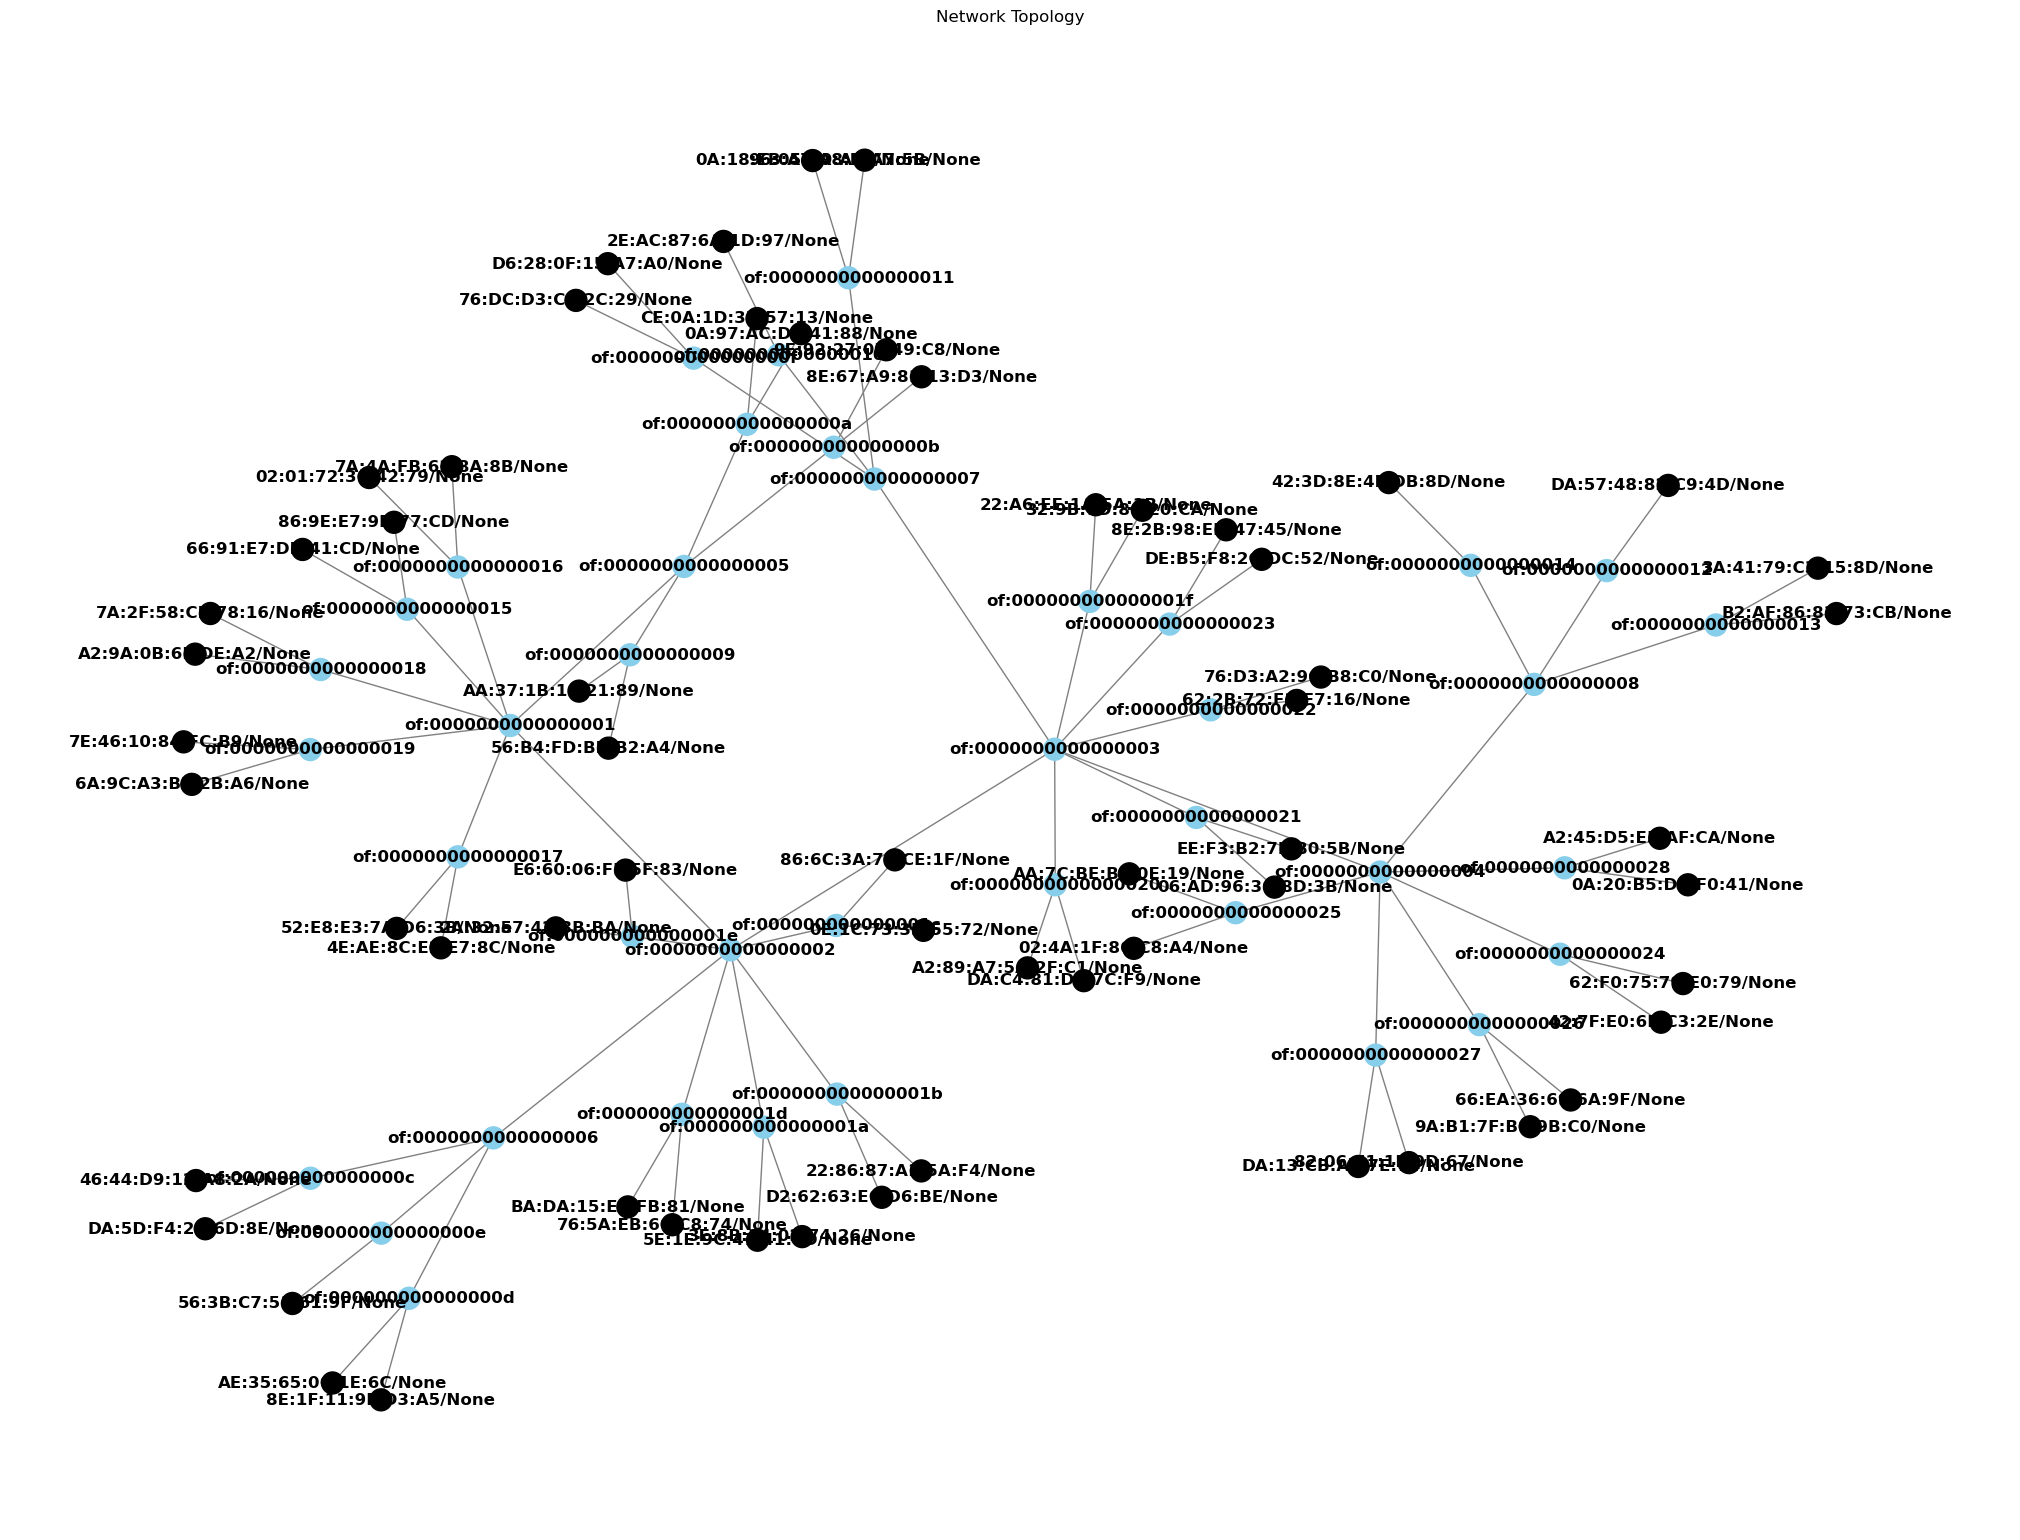

In [15]:
# Visualize the network topology
visualize_network(devices, links, hosts)

#### 2. Extracting the traffic matrix from the network topology

> Using offshore WPP data services and requirements, select source-destination hosts were selected to represent the **three case scenarios**: (a) Critical, time sensitive data transfer, (b) Critical, delay tolerant data transfer, (c) Best effort data transfer.

>Link utilization refers to the ratio of the traffic on a link to the total available bandwidth. For this, from the port statistics in the OBSERVE module, use the BytesSent and BytesReceived to compute link utilization. Considering the link bandwidth and time interval between statistics collection.

##### 2a. Reading the link utilization

In [16]:
link_bandwidth = 150   #Setting a common bandwidth for all links (150mbps)

##### 2b. Reading the path latency

##### 2c. Reading the device temperatures

#### 3. QoS/SLA Thresholds

> The ABSTRACTION Module gathers the **user intents** - which are the desired outcomes or needs that guide the network design and service management - from the Operations and Maintenance personnel, business executives, regulators, and other key stakeholders. The ABSTRACTION Module converts these **user intents** to **system intents** which are high-level network configurations and policies. 

> Temperature Threshold source: ASHRAE Technical Committee (TC) 9.9, “Data center power equipment thermal guidelines and best practices.” (2016) https://www.ashrae.org/File%20Library/Technical%20Resources/Bookstore/ASHRAE_TC0909_Power_White_Paper_22_June_2016_REVISED.pdf


![Graphical Abstract](Decide_Module.png)

In [17]:
#Defines the N_req values
L_threshold = 80  #Link Utilization threshold (%)
U_threshold = 3   #Path latency (ms)
t_Threshold = np.arange(18,27,0.01)   #Operating Temperature (Data Center Power Equipment Thermal Guidelines and Best Practices)

## DECIDE MODULE

> Check for QoS/SLA threshold violations 

> Run the decide module script in a tensorflow environment: https://github.com/PinaPhD/JP3/blob/main/KnowledgePlane/Decide.py

## ACT MODULE

> Run the act module script: https://github.com/PinaPhD/JP3/blob/main/KnowledgePlane/Act.py

## DATA ANALYSIS

In [57]:
#Loading the Iperf3 data files
dqn_df = pd.read_csv('C:/Users/amwangi254/Desktop/JP3/DataPlane/iperf3_data/dqn_results.csv') 
dijkstra_df = pd.read_csv('C:/Users/amwangi254/Desktop/JP3/DataPlane/iperf3_data/dijkstra_ecmp_results.csv')

2024-09-20 12:28:53,815 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-20 12:28:53,837 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-20 12:28:53,864 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-20 12:28:53,886 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-20 12:28:53,892 - INFO - Using categorical units to plot a list of strings that are all parsable as 

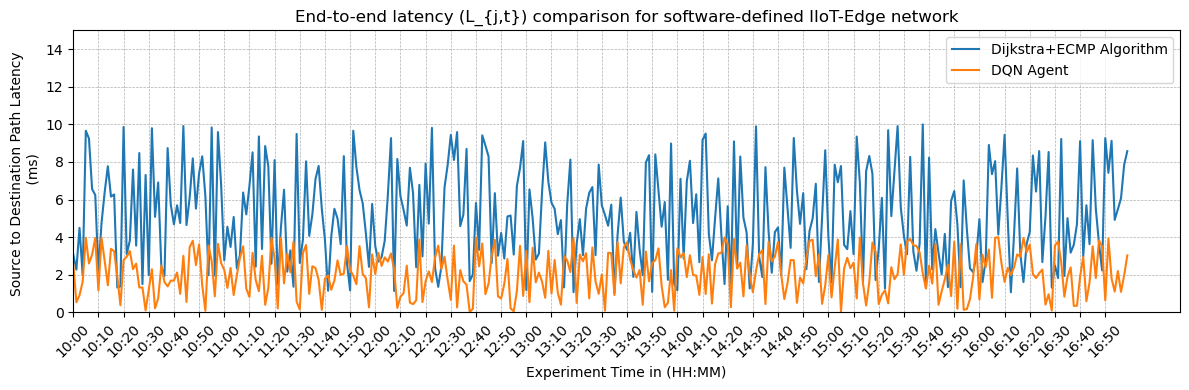

In [72]:
import datetime
# Function to convert time in seconds to actual time starting from 10:00 AM
def convert_to_time(seconds):
    base_time = datetime.datetime.strptime('10:00:00', '%H:%M:%S')  # Starting at 10 AM
    return (base_time + datetime.timedelta(seconds=seconds)).strftime('%H:%M')

# Apply the time conversion to both dataframes
dijkstra_df['Time (actual)'] = dijkstra_df['Time (seconds)'].apply(convert_to_time)
dqn_df['Time (actual)'] = dqn_df['Time (seconds)'].apply(convert_to_time)

# Plot Latency comparison with spaced tickers (every 10 minutes)
plt.figure(figsize=(12, 4))
plt.plot(dijkstra_df['Time (actual)'], dijkstra_df['Latency (ms)'], label='Dijkstra+ECMP Algorithm')
plt.plot(dqn_df['Time (actual)'], dqn_df['Latency (ms)'], label='DQN Agent')

# Set tickers for every 10 minutes
plt.xticks(dijkstra_df['Time (actual)'][::500 // 60], rotation=45)  

# Adjust Y-axis to add space at the top and start from zero
plt.ylim(0, dijkstra_df['Latency (ms)'].max() + 5)
# Set the x-axis limit to start at 0
plt.xlim(left=0)

# Set legend at the top right
plt.legend(loc='upper right')

# Add grid lines and make them less prominent
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlabel('Experiment Time in (HH:MM)')
plt.ylabel('Source to Destination Path Latency \n (ms)')
plt.title('End-to-end latency (L_{j,t}) comparison for software-defined IIoT-Edge network')
plt.tight_layout()
plt.show()



---

#### With Thanks,

![funding organizations](Funding.jpg)

The Innovative Tools for Cyber-Physical Energy Systems (InnoCyPES) project has received funding from the European Union’s Horizon 2020 research and innovation programme under the Marie Sklodowska Curie grant agreement No 956433.
